# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to work in pairs. 

Answers to many questions may benefit from using more than one cell, as well as a combination of markdown and code cells.

Put helper functions into a separate script (e.g. `hwutils.py`) so they can be commented on easily and focus the notebook on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.

I discussed with Qifan, Yumin, Ceclia and Cathy.

In [1]:
# useful libraries to import
import os
import pandas as pd
import numpy as np

import sklearn.preprocessing
import sklearn.decomposition
from sklearn.manifold import MDS

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

In [2]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('/Users/hanyiwang/Desktop/qbio577_fall2022/data/ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('/Users/hanyiwang/Desktop/qbio577_fall2022/data/ENCODE_GRCh38_bigWig_metadata.tsv')

/Users/hanyiwang/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?

As illustrated in the below Chip-seq signal plots for the first 6 profiles in the dataset, there shows a dip at around 40Mb. After searching about background information about chr10, we find this is also the approximate position of the centromere. 

We hypothesis that this could be because Chip-seq technique is not as easy sequencable as the other parts. Additionally, it could be because the centromeric area is not transcript rich, resulting in low Chip-seq signals.

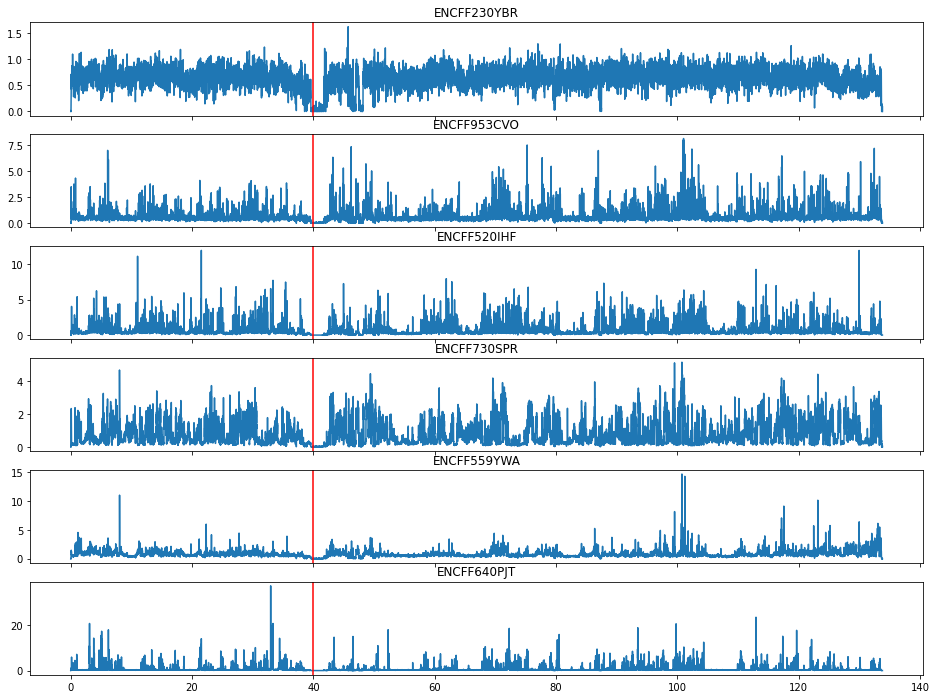

In [3]:
x = np.arange(0, 133.8, 0.01)

fig, ax = plt.subplots(6,sharex = True,figsize=(16,12))
for i in range(0,6):
    ax[i].plot(x,df.iloc[:,i+3])
    ax[i].set_title(list(df.columns)[i+3])
    ax[i].axvline(40,color='r')

- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


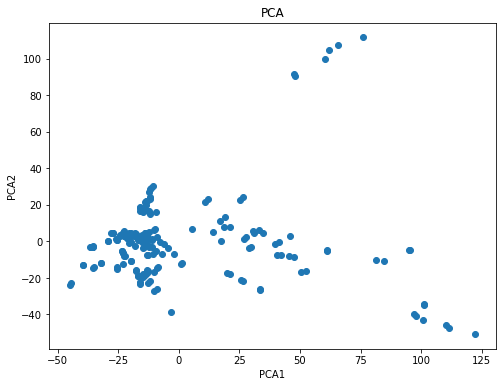

In [4]:
pca1 = sklearn.decomposition.PCA(2)  # project from 64 to 2 dimensions
projected1 = pca1.fit_transform(np.transpose(df.iloc[:,3:].values))

plt.figure(figsize=(8, 6))
plt.scatter(projected1[:, 0], projected1[:, 1])
plt.xlabel('PCA1');plt.ylabel('PCA2');plt.title('PCA');plt.show()

- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

After studying the columns of the metadata, it seems that non of the columns provide a good category for detecting and removing outliers. 

In the plot "PCA colored by Assay", we can see that histone is more spread out, while transcription factors are more packed together. This indicates that PCA captures the variance in histone better than in TFs.

In the plot "PCA colored by biosample term name", we can see that the the "outliers" on the upper right corner of the plot are mainly from fibroblast of dermis cells, and the lower right corner are mainly from thyroid gland cells. The term "outliers" in PCA analysis could be ambiguous, but there might be some interesting patterns in these cell type groups.

In [5]:
########## filter metadata for this df and then reindex ##########
bigwig_df = bigwig_metadata[bigwig_metadata['File accession'].isin(df.columns[3:])]
bigwig_df = bigwig_df.set_index('File accession').reindex(df.columns[3:]).reset_index()

In [6]:
########## understand columns, find useful categories ##########
for i in range(0,59):
    print(i,list(bigwig_df.columns)[i],len(bigwig_df.iloc[:,i].unique()))

print(bigwig_df.iloc[:,7].unique())

0 index 200
1 Unnamed: 0 200
2 File format 1
3 File type 1
4 File format type 1
5 Output type 1
6 File assembly 1
7 Experiment accession 79
8 Assay 3
9 Donor(s) 35
10 Biosample term id 36
11 Biosample term name 36
12 Biosample type 4
13 Biosample organism 1
14 Biosample treatments 4
15 Biosample treatments amount 4
16 Biosample treatments duration 4
17 Biosample genetic modifications methods 2
18 Biosample genetic modifications categories 2
19 Biosample genetic modifications targets 3
20 Biosample genetic modifications gene targets 1
21 Biosample genetic modifications site coordinates 1
22 Biosample genetic modifications zygosity 1
23 Experiment target 45
24 Library made from 1
25 Library depleted in 1
26 Library extraction method 1
27 Library lysis method 1
28 Library crosslinking method 2
29 Library strand specific 1
30 Experiment date released 20
31 Project 3
32 RBNS protein concentration 1
33 Library fragmentation method 9
34 Library size range 4
35 Biological replicate(s) 10
36 Te

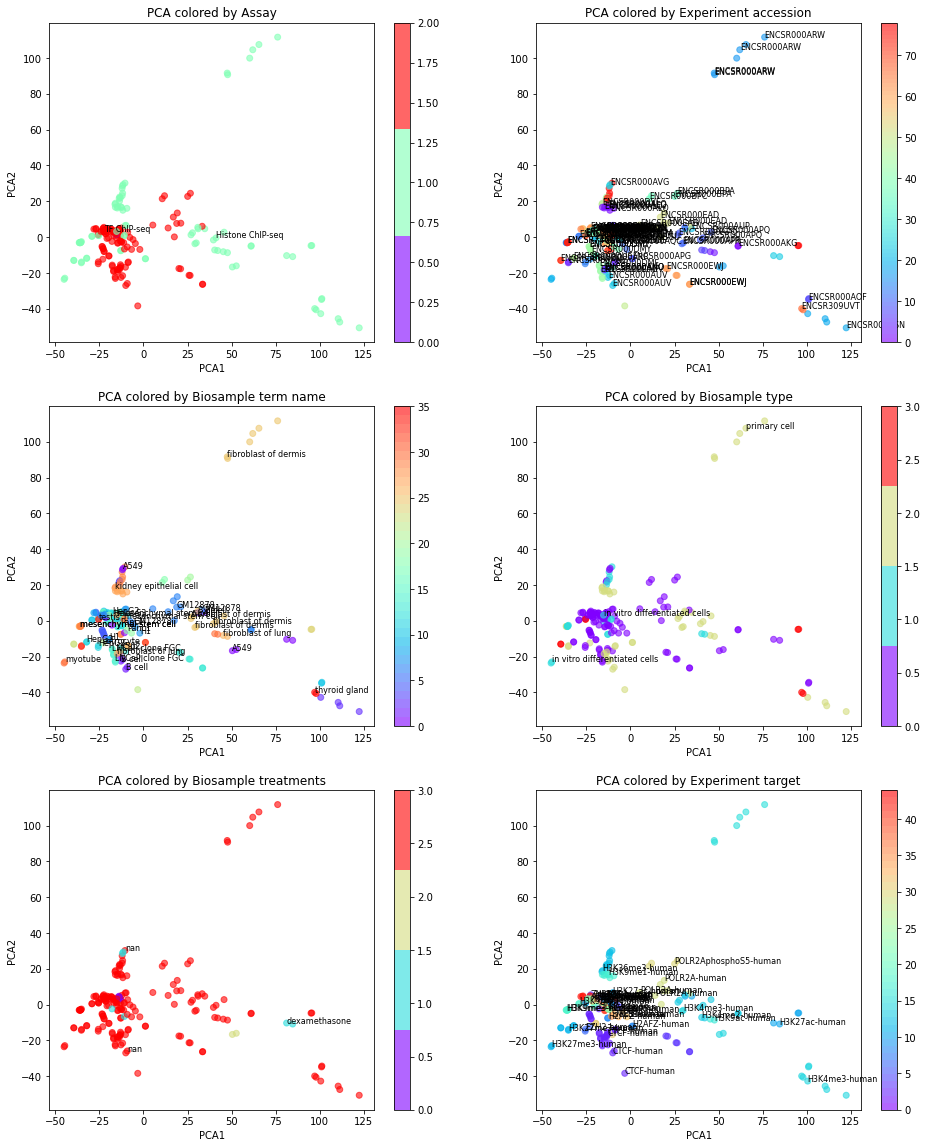

In [7]:
########## encode columns and plot colored PCA ##########
cols = ['Assay','Experiment accession',
        'Biosample term name','Biosample type',
        'Biosample treatments','Experiment target']
le = sklearn.preprocessing.LabelEncoder()

fig, axes = plt.subplots(3,2, figsize=(16, 10 * 2))
axes = axes.ravel() 

for i,feature in enumerate(cols):
    # encode feature column
    le_feature = le.fit(bigwig_df[feature].unique())
    coded_feature = le.transform(bigwig_df[feature])
    feature_names = le.inverse_transform(coded_feature)
    
    # PCA colored scatter plot
    scatter = axes[i].scatter(projected1[:, 0], projected1[:, 1], 
                              c=coded_feature, alpha = 0.6,
                              cmap=plt.cm.get_cmap('rainbow',len(bigwig_df[feature].unique())))
    axes[i].set(xlabel='PCA1',ylabel='PCA2',title= f"PCA colored by {feature}")
    plt.colorbar(scatter,ax = axes[i])
    
    # text illustrate categories
    for idx in (np.where(np.diff(np.sort(coded_feature))!= 0)[0]): # only text 'new' points
        axes[i].text(projected1[idx,0], projected1[idx, 1], str(feature_names[idx]), fontsize=8)
plt.show()

- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types (biosample term names)? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.

We first compute the autocorrelation matrix based on position for the dataset, and then group them by experiment targets. The autocorrelation plot for different targets shows that most of them drops fast. After setting a threshold of 0.9, with >0.9 being broad pattern proteins and <0.9 being narrow pattern proteins, there are in total 26 proteins shows broad pattern, and 19 proteins shows narrow pattern.

We also colored the PCA plot based on the broad/narrow pattern and found 2 obvious consistent groups.

In [8]:
########## calculate autocorrelaiton matrix ##########
auto_corr_by_row = []
for row in np.transpose(df.iloc[:,3:].values):
    auto_corr = np.correlate(row, row, mode='full')
    auto_corr = auto_corr[len(row)-1:]  # Take only the positive lags
    auto_corr /= np.max(auto_corr)  # Normalize the auto-correlation
    auto_corr_by_row.append(auto_corr)

In [ ]:
########## group and study the pattern for each cell type ##########
autocorr =  pd.DataFrame(auto_corr_by_row)
autocorr['Experiment target']=bigwig_df['Experiment target']
autocorr['Biosample term name']=bigwig_df['Biosample term name']

mean_ExperimentTarget = autocorr.groupby('Experiment target').mean()
# mean_ExperimentTarget

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(45):
    plt.plot(x,mean_ExperimentTarget.iloc[i,:],alpha = 0.5)
    plt.axhline(0.9,color = 'red')
plt.title('Autocorrelation for different Experiment targets');plt.show()

In [ ]:
broad = mean_ExperimentTarget[mean_ExperimentTarget.iloc[:,1]>0.9].index.tolist() # threshold 0.9
# len(broad)

########## Add broad or narrow pattern to bigwig_df ##########
bigwig_df['Broad pattern'] = [i in broad for i in bigwig_df['Experiment target']]

########## plot PCA colored by broad or narrow pattern ##########
plt.figure(figsize=(8, 6))
colors = {True: 'green', False: 'red'}
plt.scatter(projected1[:, 0], projected1[:, 1], 
            c=bigwig_df['Broad pattern'].map(colors), label='Data Points')
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Broad', markersize=10, markerfacecolor='green'),
           plt.Line2D([0], [0], marker='o', color='w', label='Narrow', markersize=10, markerfacecolor='red')]
plt.legend(handles=handles, loc='best')
plt.xlabel('PCA1');plt.ylabel('PCA2');
plt.title('PCA colored by Broad/narrow pattern');plt.show()

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


In [ ]:
########## marker based on Assay
marker_mapping = {'TF ChIP-seq': 'o', 'Histone ChIP-seq': 's','ATAC-seq':'^'}
marker_Assay = [marker_mapping[value] for value in bigwig_df['Assay']]

########## color based on Experiment target
le_target = le.fit(bigwig_df['Experiment target'].unique())
coded_target = le.transform(bigwig_df['Experiment target'])

cmap = plt.get_cmap('rainbow',45)
colors = [cmap(i/45) for i in range(45)]

########## PCA colored based on Assay and Experiment target
plt.figure(figsize=(8, 6))
for i in range(200):
    plt.scatter(projected1[i, 0], projected1[i, 1], marker=marker_Assay[i],c=[colors[coded_target[i]]])
plt.xlabel('PCA1');plt.ylabel('PCA2');
plt.title('PCA colored by Broad/narrow pattern');plt.show()

- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 

Below is the scattered PCA plot on the standardized dataset, colored by broad/narrow patterns. 

From my perspective, this dataset shouldn't be standardized. It seems like the binned dataset is already normalized, where all the signals have a value between 0 and 1. Also, we shouldn't assume the signal value follows a normal distribution. After standardization, the PCA is just spread out with little information to read about the patterns we have seen before. Thus standardize it by mean and variance is not ideal for this dataset.

In [ ]:
########## remove centromeric region ##########
df_rc = df.drop(df.index[3900:4200])

########## standardize ##########
sc = sklearn.preprocessing.StandardScaler()
df_sd = np.transpose(sc.fit_transform(df_rc.iloc[:,3:].values))
                                                                                 
########## PCA on standardized df ##########
pca2 = sklearn.decomposition.PCA()
projected2 = pca2.fit_transform(df_sd)

plt.figure(figsize=(8, 6))
colors = {True: 'green', False: 'red'}
plt.scatter(projected2[:, 0], projected2[:, 1], 
            c=bigwig_df['Broad pattern'].map(colors), label='Data Points')
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Broad', markersize=10, markerfacecolor='green'),
           plt.Line2D([0], [0], marker='o', color='w', label='Narrow', markersize=10, markerfacecolor='red')]
plt.legend(handles=handles, loc='best')
plt.xlabel('PCA1');plt.ylabel('PCA2');
plt.title('PCA on standardized data colored by Broad/narrow pattern');plt.show()

- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 

45 PCs can explain 90% of the variance in the data.

In [ ]:
explained_variance_ratio = pca2.explained_variance_ratio_
# np.where(np.cumsum(explained_variance_ratio)>0.9)[0][0]

plt.figure(figsize=(8, 6))
bar_plot = plt.bar(range(1, len(explained_variance_ratio) + 1), 
                   explained_variance_ratio, alpha=0.5, align='center')
step_plot = plt.step(range(1, len(explained_variance_ratio) + 1), 
                     np.cumsum(explained_variance_ratio), where='mid')
plt.legend([bar_plot[0], step_plot[0]], ['Explained Variance', 'Cumulative Explained Variance'])
plt.xlabel('Principal Components');plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot');plt.show()

- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.

Here we can see that the MDS processed data is more sparsed, with some pattern shown about the 2 groups regarding the broad/narrow Chip-seq signal patterns.

PCA can help understand which variables contribute to the variance of the data, which in this case is helpful for us to see which feature is important for interpreting the patterns in the Chip-seq signals.

MDS plots the data into lower-dimensions while remaining the pairwise distance between data points unchanges. As for this dataset, it is not helpful for interpreting the patterns, but is helpful for detecting similar or dissimilar data points' groups.

In [ ]:
mds = MDS()
embedding = mds.fit_transform(df_sd)

plt.figure(figsize=(8, 6))
colors = {True: 'green', False: 'red'}
plt.scatter(embedding[:, 0], embedding[:, 1], 
            c=bigwig_df['Broad pattern'].map(colors), label='Data Points')
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Broad', markersize=10, markerfacecolor='green'),
           plt.Line2D([0], [0], marker='o', color='w', label='Narrow', markersize=10, markerfacecolor='red')]
plt.legend(handles=handles, loc='best')
plt.xlabel('PCA1');plt.ylabel('PCA2');
plt.title('PCA on standardized data colored by Broad/narrow pattern');plt.show()

- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).

Non-negative matrix factorization could be a useful method for this dataset, given that this dataset contains only non-negative values. Also, there are many 0 values in the dataset, NMF can be very helpful for reducing dimensions in this case.